Additionally, geographical data can be used to improve the similarity and clustering of the the languages. It stands to reason that languages whose geographical centers are nearer to each other will have their respective populations interact with each other more often, encouraging the exchange of phonology and shared concepts between the two languages. The effect of such interactions between two populations of a language may not be captured by a lexical analysis alone.

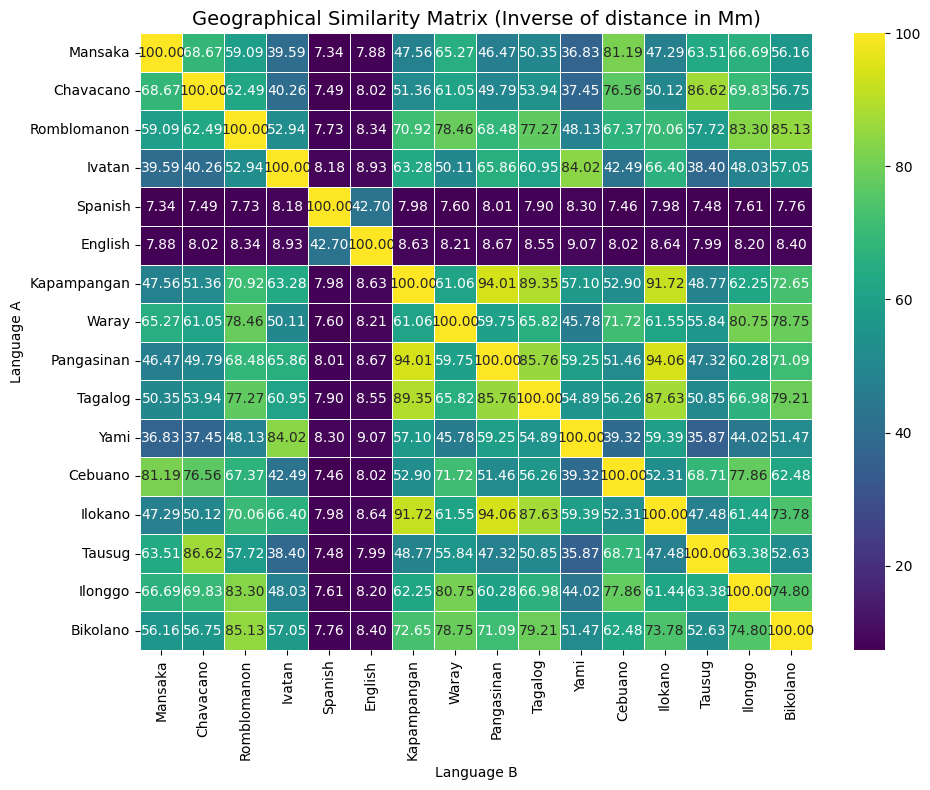

In [58]:
import pandas as pd
import numpy as np
import io
#!python -m pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org geopy
from geopy.distance import great_circle
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

# Manually load the data because I have had it with these paths.
# These coordinates were obtained from each language's respective Ethnologue page
geo_csv_data = """
language,x,y
Mansaka,126.1601,7.28
Chavacano,122.0318,7.0362
Romblomanon,122.5741,12.4086
Ivatan,121.9454,20.3815
Spanish,-3.5465,40.3952
English,-0.2397,52.2486
Kapampangan,120.3393,15.3912
Waray,125.0539,11.9388
Pangasinan,120.3852,15.962
Tagalog,121.1581,14.6678
Yami,121.5444,22.05
Cebuano,124.4179,8.448
Ilokano,120.9751,15.9247
Tausug,121.127,5.9765
Ilonggo,123.2482,10.7304
Bikolano,123.4033,13.7557
"""

geo_data_file = io.StringIO(geo_csv_data)
geo_centers = pd.read_csv(geo_data_file, index_col=0)

languages = geo_centers.index.tolist()
geo_sim_matrix = pd.DataFrame(index=languages, columns=languages, dtype=float)

for lang_a, lang_b in product(languages, languages):
    # Retrieve coordinates. 'y' is latitude, 'x' is longitude.
    coords_1 = (geo_centers.loc[lang_a, 'y'], geo_centers.loc[lang_a, 'x'])
    coords_2 = geo_centers.loc[lang_b, 'y'], geo_centers.loc[lang_b, 'x']
    
    # Calculate similarity and populate matrix
    # Distance between two points on the globe is the great circle distance (in km) between the two points
    # The similarity is given as 100 / (1 + distance_km / 1000)
    # The numerator, 100, ensures that similarity scores are normalized between 0 and 100
    # The denominator uses the megameters for improved quality of the similarity score scale
    distance_km = great_circle(coords_1, coords_2).kilometers
    geo_sim_matrix.loc[lang_a, lang_b] = 100 / (1 + distance_km / 1000)
    geo_sim_matrix.loc[lang_b, lang_a] = 100 / (1 + distance_km / 1000)

geo_sim_matrix

plt.figure(figsize=(10, 8))
sns.heatmap(geo_sim_matrix.astype(float), annot=True, cmap="viridis", fmt=".2f", linewidths=.5)
plt.title("Geographical Similarity Matrix (Inverse of distance in Mm)", fontsize=14)
plt.xlabel("Language B")
plt.ylabel("Language A")
plt.tight_layout()
plt.show()

The similarity matrix of language geographic centers further emphasizes the difference between the European languages, namely, English and Spanish, and the Filipino languages. With the English language being centered in the United Kingdom, and the Spanish language in Spain, they are geographically centered very far compared to the Filipino languages. However, it is important to note that English's use across the globe as a lingua franca and Spanish's use in many different territotities makes it difficult to associate these languages with a single locality.

This matrix also captures important data that was missing from the lexical similarity matrix. In particular, Chavacano, whose lexical similarity score with Spanish was 81.09, has a geographical similarity score of 7.49 with the Spanish language. This drastic change in the two similarity scores represents two dimensions: the development of Chavacano in the proximity of other Philippine languages and its status as a Spanish creole.

These two similarity scores both describe the similarity of each language to every other language, but each similarity score represents different dimensions or attributes that two languages are similar/different in. One way to summarize these two scores is to apply a weight to each similarity score, representing how much influence each similarity score has on the final similarity score value. We set the weight of the lexical similarity score to be 0.75 while the geographical similarity score has a weight of 0.25.

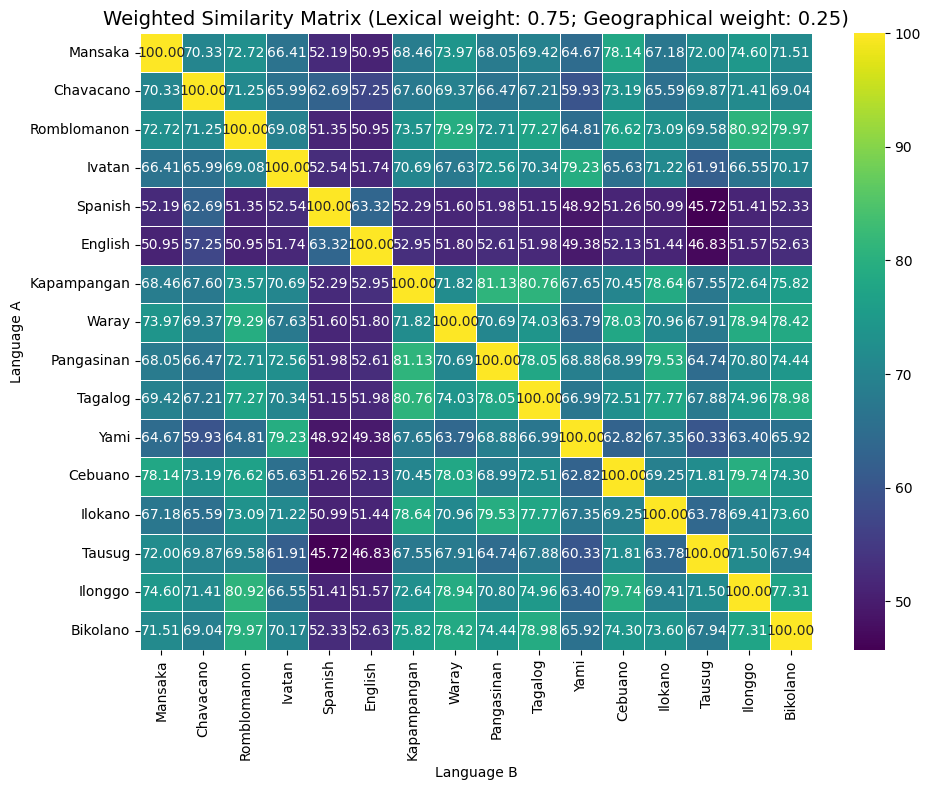

In [67]:
lex_csv_data = """ 
,Mansaka,Chavacano,Romblomanon,Ivatan,Spanish,English,Kapampangan,Waray,Pangasinan,Tagalog,Yami,Cebuano,Ilokano,Tausug,Ilonggo,Bikolano
Mansaka,100.0,70.8795437841147,77.265690733397,75.34423172242853,67.14372108939418,65.30979792726905,75.42400908169923,76.86859268295551,75.23922203085849,75.77876427539792,73.95234402087313,77.12851526533791,73.81633726239134,74.82870632871949,77.23074627916615,76.62861237387042
Chavacano,70.8795437841147,100.0,74.17177677763449,74.5677994380172,81.09287358663143,73.65920998070496,73.01314191745011,72.14633623306415,72.03660604952306,71.63839323972985,67.41702642348827,72.06281526278552,70.74083519998482,64.2883580974011,71.93449908358201,73.138924885237
Romblomanon,77.265690733397,74.17177677763449,100.0,74.45630303117002,65.89609493762332,65.1492378554668,74.45497297499644,79.57310767469849,74.11543699000119,77.27592027791725,70.36985023768679,79.70167274446685,74.1035045749844,73.53362708946052,80.1224767502999,78.24508864097172
Ivatan,75.34423172242853,74.5677994380172,74.45630303117002,100.0,67.32780765412762,66.00789201228399,73.15689760504901,73.46991244555367,74.78947583124325,73.47169013495994,77.62727127537694,73.3430513517722,72.82815389759288,69.74623935861227,72.71980650319408,74.540241762761
Spanish,67.14372108939418,81.09287358663143,65.89609493762332,67.32780765412762,100.0,70.19502186930939,67.06036491424625,66.26147319887272,66.63762844346589,65.56781954298033,62.46418784210754,65.86149694759867,65.32342458027466,58.46702748129942,66.00610864468477,67.1894368875914
English,65.30979792726905,73.65920998070496,65.1492378554668,66.00789201228399,70.19502186930939,100.0,67.7211275049797,66.32687256987278,67.25841319853284,66.46237878800255,62.819972630272375,66.83794335629399,65.70332586512939,59.77936550524173,66.02565159645054,67.37056296514446
Kapampangan,75.42400908169923,73.01314191745011,74.45497297499644,73.15689760504901,67.06036491424625,67.7211275049797,100.0,75.4022651297315,76.8334876551225,77.90239535517408,71.16426532820743,76.29371643944313,74.28182495262513,73.8045562131865,76.10764556982303,76.8775881452963
Waray,76.86859268295551,72.14633623306415,79.57310767469849,73.46991244555367,66.26147319887272,66.32687256987278,75.4022651297315,100.0,74.3374979981512,76.77035226957754,69.78768495418032,80.13344826666851,74.08906793335993,71.92996522339733,78.33470898136072,78.30535035883986
Pangasinan,75.23922203085849,72.03660604952306,74.11543699000119,74.78947583124325,66.63762844346589,67.25841319853284,76.8334876551225,74.3374979981512,100.0,75.48384248202093,72.09554310293818,74.83384916711327,74.68594673918919,70.55320929997215,74.3111526131361,75.55509238636378
Tagalog,75.77876427539792,71.63839323972985,77.27592027791725,73.47169013495994,65.56781954298033,66.46237878800255,77.90239535517408,76.77035226957754,75.48384248202093,100.0,71.021596838795,77.92324809054448,74.4788555474309,73.56106682601748,77.61520586598743,78.90078314172143
Yami,73.95234402087313,67.41702642348827,70.36985023768679,77.62727127537694,62.46418784210754,62.819972630272375,71.16426532820743,69.78768495418032,72.09554310293818,71.021596838795,100.0,70.65072770481015,70.00318451421755,68.48703593211931,69.86429015458769,70.73709294513242
Cebuano,77.12851526533791,72.06281526278552,79.70167274446685,73.3430513517722,65.86149694759867,66.83794335629399,76.29371643944313,80.13344826666851,74.83384916711327,77.92324809054448,70.65072770481015,100.0,74.90118384991739,72.84622091601716,80.36155194658342,78.24448413576334
Ilokano,73.81633726239134,70.74083519998482,74.1035045749844,72.82815389759288,65.32342458027466,65.70332586512939,74.28182495262513,74.08906793335993,74.68594673918919,74.4788555474309,70.00318451421755,74.90118384991739,100.0,69.2125797674952,72.07166389682807,73.5428547860874
Tausug,74.82870632871949,64.2883580974011,73.53362708946052,69.74623935861227,58.46702748129942,59.77936550524173,73.8045562131865,71.92996522339733,70.55320929997215,73.56106682601748,68.48703593211931,72.84622091601716,69.2125797674952,100.0,74.20160372461818,73.0384147319308
Ilonggo,77.23074627916615,71.93449908358201,80.1224767502999,72.71980650319408,66.00610864468477,66.02565159645054,76.10764556982303,78.33470898136072,74.3111526131361,77.61520586598743,69.86429015458769,80.36155194658342,72.07166389682807,74.20160372461818,100.0,78.14936805575262
Bikolano,76.62861237387042,73.138924885237,78.24508864097172,74.540241762761,67.1894368875914,67.37056296514446,76.8775881452963,78.30535035883986,75.55509238636378,78.90078314172143,70.73709294513242,78.24448413576334,73.5428547860874,73.0384147319308,78.14936805575262,100.0
"""

lex_data_file = io.StringIO(lex_csv_data)
lex_sim_matrix = pd.read_csv(lex_data_file, index_col=0)

percent_lex = 0.75

weighted_sim_matrix = lex_sim_matrix * percent_lex + (1 - percent_lex) * geo_sim_matrix

plt.figure(figsize=(10, 8))
sns.heatmap(weighted_sim_matrix.astype(float), annot=True, cmap="viridis", fmt=".2f", linewidths=.5)
plt.title(f"Weighted Similarity Matrix (Lexical weight: {percent_lex}; Geographical weight: {1 - percent_lex})", fontsize=14)
plt.xlabel("Language B")
plt.ylabel("Language A")
plt.tight_layout()
plt.show()

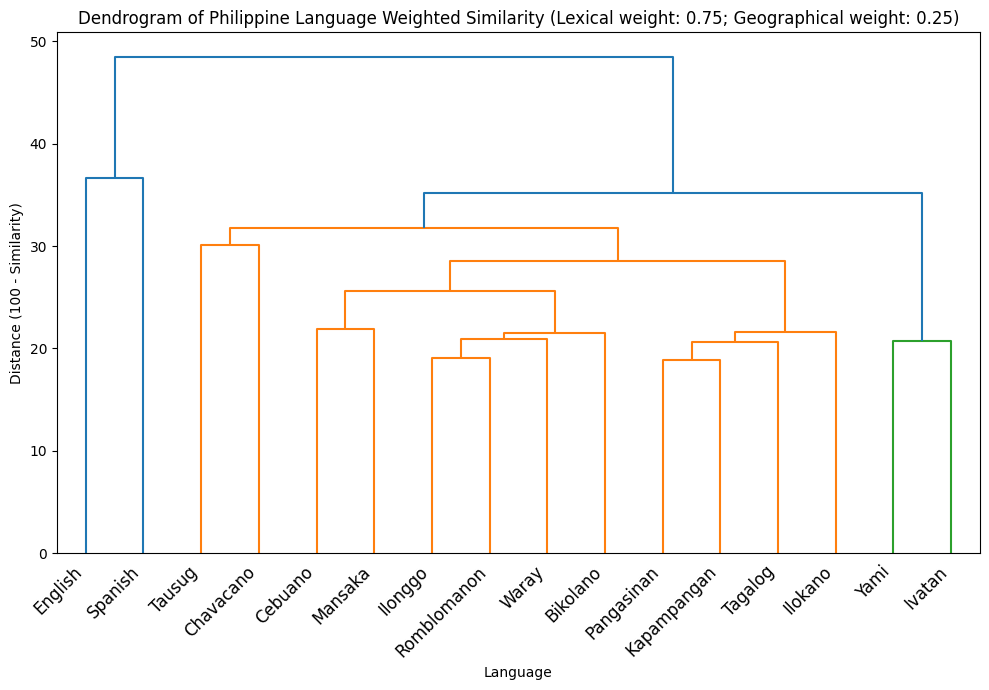

In [64]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# Convert similarity to distance
# Assuming 100% similarity means 0 distance
distance_matrix = 100 - weighted_sim_matrix

# Convert the distance matrix to a condensed distance matrix required by linkage
condensed_distance_matrix = squareform(distance_matrix)

linked = linkage(condensed_distance_matrix, 'weighted')

plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           labels=languages,
           distance_sort='descending',
           show_leaf_counts=True)
plt.title(f'Dendrogram of Philippine Language Weighted Similarity (Lexical weight: {percent_lex}; Geographical weight: {1 - percent_lex})')
plt.xlabel('Language')
plt.ylabel('Distance (100 - Similarity)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()